### O problema analizado é o caixeiro viajante com cidades dispostas ao longo de uma esctrela. O problema é equivalente ao de cidades dispostas ao longo de um circulo, mas com raio variável. Os mínimos continuam sendo os casos em que as cidades seguem ordem crescente ou decrescente.


In [1]:
using LinearAlgebra
using Plots
using TimerOutputs
using Waveforms
using Distributed;
using ProgressMeter
using Profile
using Dagger

#Definiçoes

const cidades = 100
const raioBase = 0.8506508

const fatorNormalizacao = 1
const raioPentagono = (raioBase .+ 0.2*trianglewave.(10*pi.*(0:cidades-1)./(cidades)) .+ 0.2)
const pos = raioPentagono.*[cos.(2 .* pi .* (0:cidades-1) ./ cidades) sin.(2 .* pi .* (0:cidades-1) ./ cidades)];

const ordemOtima = 1:cidades

1:100

In [2]:
using LinearAlgebra

custosTemp = zeros(Float32, cidades, cidades)

for i = 1:cidades
    for j in 1:cidades
        custosTemp[i, j] = norm(pos[i, :]-pos[j, :])
    end
end

const custos = custosTemp;

In [3]:
function J(ordem)
    distTot = 0.0
    for i = 2:cidades
        distTot += custos[ordem[i], ordem[i-1]]    
    end
    
    distTot += custos[ordem[end], ordem[1]]
    
    return distTot
end

J (generic function with 1 method)

In [4]:
function J(ordem, cIdx = 0)
    distTot = 0.0
    for i = 2:cidades
        if cIdx == 0
            distTot += custos[ordem[i], ordem[i-1]]
        else    
            distTot += custos[ordem[cIdx, i], ordem[cIdx, i-1]]
        end
    end
    
    if cIdx == 0
        distTot += custos[ordem[end], ordem[1]]
    else
        distTot += custos[ordem[cIdx, end], ordem[cIdx, 1]]
    end
    
    return distTot
end

J (generic function with 2 methods)

In [5]:
function PMX(p1, p2, child)
    csize = length(p1)
    child .= 0
    
    #1
    
    i1 = rand(1:csize)
    i2 = rand(1:csize)

    if i1 > i2
        i1, i2 = i2, i1
    end
    
    # explicito para reduzir alocacoes
    for i = i1:i2
        child[i] = p1[i]
    end
    
    #2
    for i = i1:i2
        rep2 = p2[i]
        found = false
        
        # usar findall()[1] gera muitas alocacoes
        rep_idx2 = findFirst(p2, rep2)
        
        # usar rep2 in child[i1:i2] gera muitas alocacoes
        # por conta do slice [i1:i2]
        for j = i1:i2
            if rep2 == child[j]
                found = true
                break
            end
        end
        while(!found)
            rep1 = p1[rep_idx2]
            rep_idx1 = findFirst(p1, rep1)
            
            if(rep_idx1 < i1 || rep_idx1 > i2)
                child[rep_idx1] = rep2
                found = true
            else
                rep_idx2 = findFirst(p2, rep1)
            end
        end
    end    
    #3
    
    for i = 1:csize
        if child[i] == 0
            child[i] = p2[i]
        end
    end
    
    return child
end

PMX (generic function with 1 method)

In [6]:
function findFirst(input, element)
    idx = 0
    for el in input
        idx += 1
        if element == el
            return idx
        end
    end
end

findFirst (generic function with 1 method)

In [7]:
function reverse(A, i1, i2)
    max = length(A)
    for i = i1:i2
        A[i] = A[max-i]
    end
end

reverse (generic function with 1 method)

In [8]:
#SR
function SR(lista, min, proximidade)
    taxa = 0
    rodadas = length(lista)
    
    for l in lista
        if(abs(min - l) <= proximidade)
            taxa += 1/rodadas
        end
    end
    
    return taxa*100
end

using Statistics

#MBF
function MBF(lista, min)   
    return min/mean(lista)
end

#AES
function AES(execsPorIt)
    taxa = 0
    rodadas = 0
    
    for exec in execsPorIt
        if exec > 0
            taxa += exec
            rodadas += 1
        end
    end
    if rodadas > 0
        taxa = taxa/rodadas
    end
    return taxa
end

AES (generic function with 1 method)

In [9]:
function SGA_cidades(Xs, gens, k, Jmin, mu, meme, depth, maxSearch, taxaMut)
    parents = Array{Int16}(undef, k, cidades)
    xhat = Array{Int16}(undef, cidades)
    child = Array{Int16}(undef, cidades)
    p1 = Array{Int16}(undef, cidades)
    p2 = Array{Int16}(undef, cidades)
    Jhist = Array{Float32}(undef, gens)
    execsHist = 0
    scores = Array{Float32}(undef, mu)
    for gen = 1:gens
        # Pontuacao  
        for i = 1:mu
            scores[i] = J(Xs, i)
            execsHist += 1
        end
        minIdx = argmin(scores)
        Jhist[gen] = scores[minIdx]
        if(abs(Jmin - scores[minIdx]) < 0.001)
#             println("Minimo encontrado");
            Jhist[gen:end] .= Jmin
            return scores[minIdx], Xs[minIdx, :], Jhist, execsHist
        end
        
        # Selecao dos Pais
        topIdx = sortperm(scores, rev=false)

        # gerava alocacoes
        # copy!(parents, Xs[topIdx[1:k], :])

        for i = 1:k
            for j = 1:cidades
                parents[i, j] = Xs[topIdx[i], j]
            end
        end
        
        
        # Crossover
        for i = 1:mu
            # gerava alocacoes
            # copy!(p1, parents[rand(1:k), :])
            # copy!(p2, parents[rand(1:k), :])

            r1 = rand(1:k)
            r2 = rand(1:k)
            for j = 1:cidades
                p1[j] = parents[r1, j]
                p2[j] = parents[r2, j]
            end
            
            Xs[i, :] = PMX(p1, p2, child)
        end
        
        # Mutacao
        for i = 1:mu
            if rand() <= taxaMut
                i1 = rand(1:cidades)
                i2 = rand(1:cidades)
                if i1 > i2
                    i1, i2 = i2, i1
                end


                Xs[i, i1:i2] = Xs[i, i2:-1:i1]
            end
        end
        
        # Memetico
        if meme
            for i = 1:mu
                for depths = 1:depth
                    Jold = J(Xs, i)
                    execsHist += 1;
                    dJ = 1
                    searches = 0
                    while dJ >=0 && searches < maxSearch
                        for j = 1:cidades 
                            xhat[j] = Xs[i, j]
                        end
                        i1 = rand(1:cidades)
                        i2 = rand(1:cidades)
                        if i1 > i2
                            i1, i2 = i2, i1
                        end
                        xhat[i1:i2] = xhat[i2:-1:i1]
                        dJ = J(xhat) - Jold
                        execsHist += 1;
                        searches += 1
                    end
                    if dJ < 0
                        for j = 1:cidades 
                            Xs[i, j] = xhat[j]
                        end
                    else
                        break
                    end
                end
            end
        end
    end
    # Pontuacao
    minIdx = argmin(scores)
#     println("Minimo nao encontrado:");
    execsHist = -1
    return scores[minIdx], Xs[minIdx, :], Jhist, execsHist
end

SGA_cidades (generic function with 1 method)

In [10]:
const runs = [100]
# const mus = [50, 100, 150, 200, 250]
const mus = [250]
# const mus = [50, 100, 150, 200, 250]
const gens = [750]
# const gens = [150, 300, 450, 600, 750]
# const ks = [1, 2]
const ks = [1, 2, 4, 6, 8, 10]
const taxaMuts = [0.4, 0.6, 0.8, 1]
const depths = [1, 2, 3, 4, 5]
depths = [3]
# const maxSearches = [10, 50, 100, 150, 200]
const maxSearches = [50]
const meme = true
const grid = true



# const runs = [100]
# const mus = [200]
# const gens = [600]
# const ks = [1, 2]
# const depths = [25]
# const maxSearches = [100]


true

In [11]:
function idx2grid(idx, meme = false)
    its = 0
    for mu in mus
        for gen in gens
            for k in ks
                for run in runs
                    for taxaM in taxaMuts
                        if meme
                            for depth in depths
                                for maxS in maxSearches
                                    its += 1
                                    if its == idx
                                        return mu, gen, k, run, depth, maxS, taxaM
                                    end
                                end
                            end
                        else
                            its += 1
                            if its == idx
                                return mu, gen, k, run, 0, 0, taxaM
                            end
                        end
                    end
                end
            end
        end
    end
    return its
end

idx2grid (generic function with 2 methods)

In [12]:
const maxIts = idx2grid(0, meme)

24

In [13]:
using ProgressMeter
using Random


if !grid
Jmin = J(ordemOtima)
mu = 300
gen = 1000
taxaMut = 0.5
k = 3
arun = 100
depth = 3
maxSearch = 100

allJmin = zeros(arun)
allExecs = zeros(arun)
allDistancias = zeros(gen, arun)

@time begin
@showprogress for j = 1:arun
    Random.seed!(j);
    
    Xs = Array{Int16}(undef, mu, cidades)
    for i = 1:mu
        Xs[i, :] = shuffle(1:cidades)
    end
     
    time = @elapsed begin
        minS, bestX, Jhist, execs = SGA_cidades(Xs, gen, k, Jmin, mu, false, depth, maxSearch, taxaMut);
    end
    allDistancias[:, j] = Jhist
    allJmin[j] = minS
    allExecs[j] = execs
end
end

println(SR(allJmin, Jmin, 0.001))
println(MBF(allJmin, Jmin))
println(AES(allExecs))
end

In [14]:
# using ProfileView
# Xs = Array{Int16}(undef, mu, cidades)
#     for i = 1:mu
#         Xs[i, :] = shuffle(1:cidades)
#     end
# @profview SGA_cidades(Xs, gen, k, Jmin, mu, meme, depth, maxSearch);  # run once to trigger compilation (ignore this one)
# Xs = Array{Int16}(undef, mu, cidades)
#     for i = 1:mu
#         Xs[i, :] = shuffle(1:cidades)
#     end
# @profview SGA_cidades(Xs, gen, k, Jmin, mu, meme, depth, maxSearch);

In [15]:
using Measures
using Plots
if !grid
step = 1
step2 = 5
plot(Jmin./allDistancias[:, 1:step2:arun],xtickfontsize=12,ytickfontsize=12, legendfontsize=10, xlabel="Gerações", ylabel="Aptidão")
plot!(1:step:(gen+100), ones(gen+100, 1), label = "Jotimo", lw = 2)
# savefig("com_meme_k1_mu200_gen700_depth3_maxS100.png")
end

In [16]:
using ProgressMeter
using Random

if grid
allSR = Array{Float32}(undef, maxIts)
allMBF = Array{Float32}(undef, maxIts)
allAES = Array{Float32}(undef, maxIts)
allTimes = Array{Float32}(undef, maxIts)

Jmin = J(ordemOtima)
proximidade = 0.001
N = maxIts*sum(runs)
p = Progress(N);
update!(p,0)
jj = Threads.Atomic{Int}(0)
l = Threads.SpinLock()
Threads.@threads for it in 1:maxIts
# @showprogress for it in 1:maxIts
    time = @elapsed begin
    mu, gen, k, arun, depth, maxS, taxaM = idx2grid(it, meme)
    allJmin = zeros(arun)
    allExecs = zeros(arun)
    for it = 1:arun
        Random.seed!(it);
        Xs = Array{Int16}(undef, mu, cidades)
        for i = 1:mu
            Xs[i, :] = shuffle(1:cidades)   
        end
        minS, ~, ~, execs = SGA_cidades(Xs, gen, k, Jmin, mu, meme, depth, maxS, taxaM);
        allJmin[it] = minS
        allExecs[it] = execs
        Threads.atomic_add!(jj, 1)
        Threads.lock(l)
        update!(p, jj[])
        Threads.unlock(l) 
    end
    allSR[it] = SR(allJmin, Jmin, proximidade)
    allMBF[it] = MBF(allJmin, Jmin)
    allAES[it] = AES(allExecs)
    end
    allTimes[it] = time
end
end

                                                                                                                                                           

In [17]:
println(allSR)
println(allMBF)
println(allAES)

Float32[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 93.0, 100.0, 100.0, 100.0, 89.0]
Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9677995, 1.0, 1.0, 1.0, 0.9613142]
Float32[748566.2, 769869.7, 815871.8, 1.2366086f6, 713811.7, 722899.8, 780031.5, 1.3937338f6, 708041.4, 790412.75, 910789.94, 2.2264022f6, 757394.7, 864930.3, 992714.3, 3.0005848f6, 802291.25, 894512.25, 1.1101482f6, 3.8996335f6, 835456.7, 941613.7, 1.1719759f6, 4.459718f6]


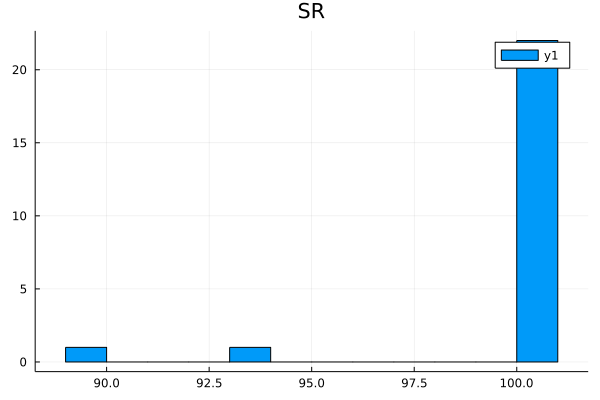

In [18]:
if grid
histogram(allSR, title = "SR")
end

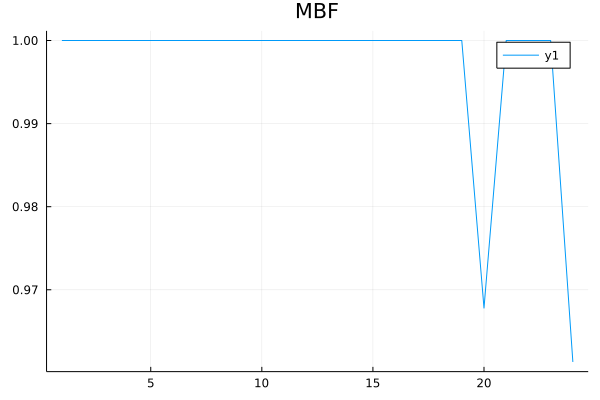

In [19]:
if grid
plot(allMBF, title = "MBF")
end

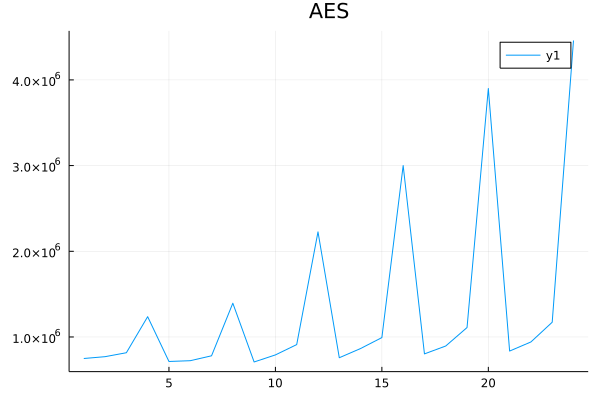

In [20]:
if grid
plot(allAES, title = "AES")
end

In [21]:
idx2grid(1)

(250, 750, 1, 100, 0, 0, 0.4)

In [22]:
# using Plots

# if ploting
    
#     bOrdem = allOrdemMin[bestCFG, :]
#     bestJ = allJmin[bestCFG]

#     println("Jmin: ", bestJ)
#     println("Jotimo: ", Jmin)
#     plot([0], [0], seriestype = :scatter, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], size = (500, 500), grid = true)
#     xt(t) = sin(t)*raioBase
#     yt(t) = cos(t)*raioBase
#     plot!(xt, yt, 0, 2*pi, leg=false)
#     plot!(pos[:, 1], pos[:, 2], seriestype = :scatter, mode="markers+text", text=0:cidades-1)

#     quiver!(pos[bOrdem, 1][:],pos[bOrdem, 2][:],quiver=(pos[[bOrdem[2:end]; bOrdem[1]], 1] - pos[bOrdem, 1][:],pos[[bOrdem[2:end]; bOrdem[1]], 2] - pos[bOrdem, 2][:])) 
# end

In [23]:
# if plotting
#     proximidade = 0.001
#     vSR = round(SR(allJmin, Jmin, proximidade), digits=2)
#     vMBF = round(MBF(allJmin), digits=2)
#     vAES = round(AES(allExecs), digits=2)
#     println("SR: ", vSR)
#     println("MBF: ", vMBF)
#     println("AES: ", vAES)
# end

In [24]:

# header: C,meme,SR,MBF,AES,mu,gens,k,depth,maxS,runs,t
if grid
    for it = 1:maxIts
        mu, gen, k, arun, depth, maxS, taxaM = idx2grid(it, meme)
        resultados = string(cidades, ",", meme, ",", allSR[it], ",", allMBF[it], ",", allAES[it], ",", mu, ",", gen, ",", k, ",", depth, ",", maxS, ",", arun, ",", taxaM, ",",allTimes[it],"\n")
    #     println(resultados)

        open("resultados_melhor2.csv","a") do io
            write(io, resultados)
        end;
    end
end